# Assignment 8

### **Q1** Sampling theorem and aliasing

<div style='background:#F0F0F0'>**1** Create a band-limited white noise timeseries with $N=1000$ entries, $dt=0.1 s$, but with all frequencies greater than 0.5 Hz filtered.  Plot the power spectrum to make sure you got it correctly...
</div>

In [66]:
import numpy.random as random
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy import interpolate
%matplotlib inline

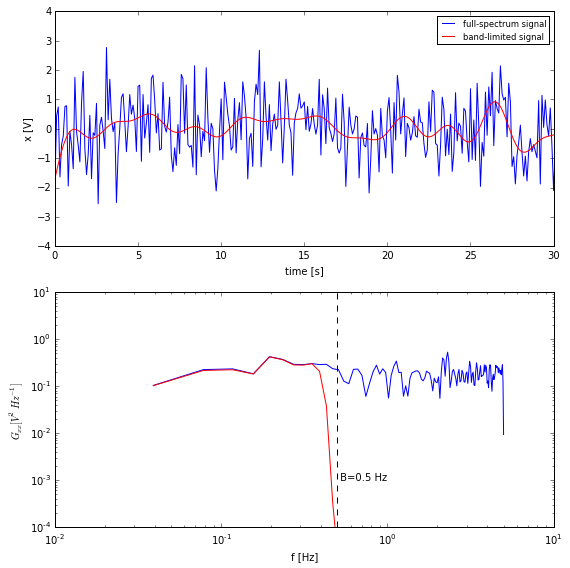

In [9]:
N = 1000
dt=0.1

x = np.random.randn(N)
t = np.arange(0,N*dt,dt)

B = 0.5
fp = 0.8*B
fs = 0.9*B
fNyq = 1/2./dt
n,fn = signal.ellipord(fp/fNyq, fs/fNyq,.1, 60.)
b,a = signal.ellip(n,.1,60.,fn)
xBL = signal.filtfilt(b,a,x)

fig,ax = plt.subplots(2,1,figsize=(8,8))

ax[0].plot(t,x,color='b',label='full-spectrum signal')
ax[0].plot(t,xBL,color='r',label='band-limited signal')
ax[0].set_xlim([0,30]);ax[0].set_xlabel('time [s]');ax[0].set_ylabel('x [V]');ax[0].legend(fontsize='small',loc=0)

nfft=256
pxx,f=mlab.psd(x,NFFT=nfft,Fs=1./dt,noverlap=nfft/2.,window=mlab.window_hanning)
pxBL,f=mlab.psd(xBL,NFFT=nfft,Fs=1./dt,noverlap=nfft/2.,window=mlab.window_hanning)

ax[1].loglog(f,pxx,color='b')
ax[1].loglog(f,pxBL,color='r')
ax[1].set_ylim([10e-5, 10e0])
plt.axvline(x=B,linestyle='--',color='k');ax[1].text(B,10e-4,' B=0.5 Hz');ax[1].set_xlabel('f [Hz]');ax[1].set_ylabel('$G_{xx} [V^2 Hz^{-1}]$')
plt.tight_layout()

**2** Now decimate by a factor of 4 to get a time series sampled at 2.5 Hz. Show that you can recover the 10 Hz time series using the Sampling Theorem.

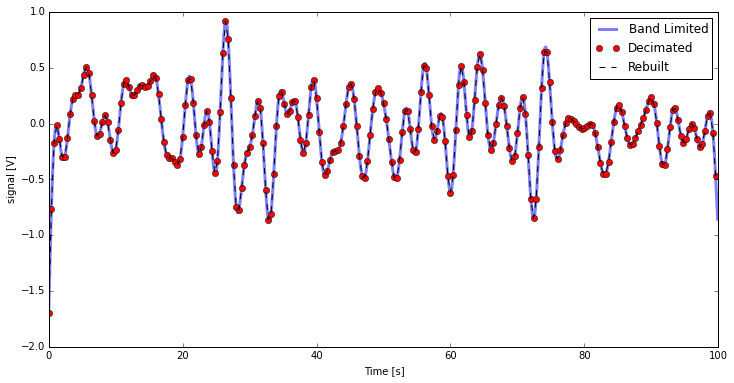

In [10]:
dec = 4
tn = t[::dec]
xn = xBL[::dec]

n = np.arange(N/dec)
xreco=1.*xBL[:N/dec]
for i in range(N/dec):
    xreco[i] = np.sum(xn[:N]*np.sinc(2.5*tn[i]-n))

fig,ax=plt.subplots(1,1,figsize=(12,6))
ax.plot(t,xBL,'b',alpha=0.5,linewidth=3,label='Band Limited')
ax.plot(tn,xn,'ro',label='Decimated')
ax.plot(tn,xreco,'k--',label='Rebuilt')
ax.set_xlabel('Time [s]');ax.set_ylabel('signal [V]')
ax.legend()

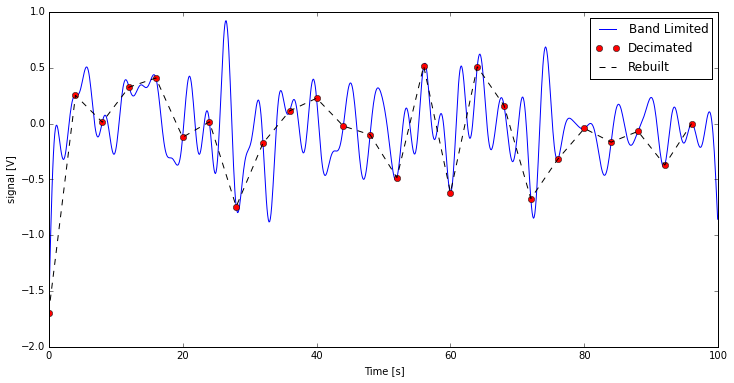

In [11]:
dec = 40
tn = t[::dec]
xn = xBL[::dec]

n = np.arange(N/dec)
xreco=1.*xBL[:N/dec]
for i in range(N/dec):
    xreco[i] = np.sum(xn[:N]*np.sinc(0.25*tn[i]-n))

fig,ax=plt.subplots(1,1,figsize=(12,6))
ax.plot(t,xBL,'b',label='Band Limited')
ax.plot(tn,xn,'ro',label='Decimated')
ax.plot(tn,xreco,'k--',label='Rebuilt')
ax.set_xlabel('Time [s]');ax.set_ylabel('signal [V]')
ax.legend()

The sampling theorem is unable to reconstruct the signal with a factor of 40 decimation, while the with a decimaion of 4, the signal was able to be reconstructed well.

## Q2: Cubic Spline
**1** Perform a cubic spline interpolation onto an even grid from 0 to 9.0 by 
  
  1. creating the matrix from the notes
  2. inverting and solving for the cubic co-efficients
  3. using those polynomials to evaluate the interpolated data.

Compare with using `scipy.interpolate.interp1d`.
Comment on any similarities or differences between the two results.

In [12]:
t = np.array([0.,2.5,2.7,3.4,4.2,6.5,9.0])
x= np.cos(t*2*np.pi/3)
T = np.diff(t)
X = np.diff(x)

In [13]:
Np = len(t)
N = Np-1

M = np.zeros((Np,Np))

for i in range(1,N):
    M[i,i-1] = T[i-1]
    M[i,i] = 2*(T[i-1]+T[i])
    M[i,i+1] = T[i]
M[0,0] = 1
M[N,N] = 1

#Mi = np.linalg.inv(M) 

D = np.zeros(Np)
for i in range(1,N):
    D[i] = 3*(X[i]/T[i]-X[i-1]/T[i-1])

C = np.linalg.solve(M,D)

print C

[ 0.          1.060137   -2.44742444 -1.48775915  1.5411677  -0.48459366
  0.        ]


In [60]:

d = np.zeros(Np)
for i in range(0,N):
    d[i] = 1/(3*T[i])*(C[i+1]-C[i])
print d

b = np.zeros(Np)
for i in range(0,N):
    b[i] = (x[i+1]-x[i]-(T[i]**2)*C[i]-(T[i]**3)*d[i])/T[i]    
print b

[ 0.1413516  -5.84593574  0.45698347  1.26205285 -0.2935886   0.06461249
  0.        ]
[-1.0834475   1.566895    1.28943751 -1.46519101 -1.42246417  1.00765611
  0.        ]


In [68]:
f = interpolate.interp1d(t, x, kind='cubic')
ty = np.arange(0, 9, 0.09)
y = f(ty)

In [69]:
NN = 100
qq = np.zeros((N,NN))
tqq = np.zeros((N,NN))

for i in range(N):
    tt = np.linspace(t[i],t[i+1],NN)
    tqq[i,] = tt
    for j in range(NN):
        qq[i,j] =  x[i] + b[i]*(tt[j]-t[i]) + C[i]*(tt[j]-t[i])**2 + d[i]*(tt[j]-t[i])**3
    

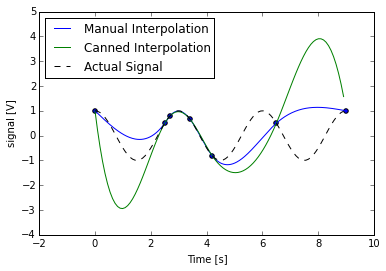

In [84]:
q = qq.flatten()
tq = tqq.flatten()
plt.scatter(t,x)
plt.plot(tq,q,label='Manual Interpolation')
plt.plot(ty,y,label='Canned Interpolation')
plt.plot(ty,np.cos(ty*2*np.pi/3),'k--',label='Actual Signal')
plt.xlabel('Time [s]');plt.ylabel('signal [V]');plt.legend(loc=2)

While neither method reproduced the period of the signal very well, the manual matrix method produced a result with similar amplitudes, while the amplitudes from the canned routine were much higher than the actual signal. A lot of this has to do with the lack of available data points. It the area where there are more points (~2-3 seconds) both methods match up quite well with the actual signal. 